In [38]:
import pandas as pd
import numpy as np
import ratmetab
from itertools import chain
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import re
from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')

In [39]:
codebookpath = '../RatMetabolites/Rat_codebook_27_Oct_2022.csv'
datapath = {
    'blood new': 'blood_27_Oct_2022',
    'brain new': 'brain_27_Oct_2022',
    'blood old': 'old_blood_17_Nov_2022',
    'brain old': 'old_brain_17_Nov_2022',
               }
data = {k: ratmetab.read_data('../RatMetabolites/Rat_' + v + '.csv', codebookpath, liberal_filter=True) for k, v in datapath.items()}

data.update({tissue: pd.concat([data[tissue + ' new'], data[tissue + ' old']], axis=0, join='outer') for tissue in ['blood', 'brain']})

def insert_centered_LIscore(dataset, data=data):
    df = data[dataset]
    s = df.LIscore - df.LIscore.mean()
    val = pd.concat([pd.DataFrame({'LIscore cent.': s}, index=df.index), df], axis=1)
    return(val)

def insert_age(dataset, data=data):
    df = data[dataset]
    l = [(lambda g: 'Y' if g == 'Y' else 'A')(group) for group in df.Group]
    val = pd.concat([pd.DataFrame({'Age': l}, index=df.index), df], axis=1)
    return(val)

data = {dataset: insert_age(dataset, data=data) for dataset in data.keys()}
data = {dataset: insert_centered_LIscore(dataset, data=data) for dataset in data.keys()}

In [40]:
codebook = pd.read_csv(codebookpath, index_col='MetaboliteName')

In [45]:
#fm4 = 'Level ~ Age + Age : Q("LIscore cent.")'
fm4 = 'Level ~ C(Age, levels=["Y", "A"]) + Age : Q("LIscore cent.")'
fm5 = 'Level ~ C(Age, levels=["Y", "A"]) * Q("LIscore cent.")'

def fit_aclass_data(aclass, formula, dat=data['blood'], codebook=codebook):
    aclass_metabolites = codebook.loc[codebook.AnalyteClass == aclass].index
    sel_metabolites = list(set(dat.columns).intersection(set(aclass_metabolites)))
    sel_cols = ['LIscore cent.', 'Age'] + sel_metabolites
    df = dat.loc[:, sel_metabolites]
    # standardization
    df = df.apply(lambda x: (x - df.mean(axis=0)) / df.std(axis=0), axis=1)
    df = df.stack(dropna=False).to_frame('Level')
    df['Age'] = np.repeat(dat.Age, len(sel_metabolites)).to_list()
    df['LIscore cent.'] = np.repeat(dat['LIscore cent.'], len(sel_metabolites)).to_list()
    df['Metabolite'] = df.index.get_level_values(1)
    df = df.dropna()
    fmod = smf.mixedlm(formula, data=df, groups='Metabolite').fit()
    return(fmod)

def extract_fit_info(fmod, aclass):
    fmod.summary()
    d = {'Estimate': fmod.params, 'SE': fmod.bse, 'p': fmod.pvalues}
    ll = [a.to_list() for a in d.values()]
    l = itertools.chain(*ll)
    ix = pd.MultiIndex.from_product([d.keys(), d['Estimate'].index])
    df = pd.DataFrame({aclass: l}, index=ix).transpose()
    df[('General', 'Converged')] = fmod.converged
    return(df)

def process_aclass(aclass, formula, dat=data['blood'], codebook=codebook):
    fmod = fit_aclass_data(aclass, formula, dat=dat, codebook=codebook)
    df = extract_fit_info(fmod, aclass)
    if aclass == 'Bile_Acids' or aclass == 'Free_Oxysterols':
        clsdata = codebook.loc[codebook.AnalyteClass == aclass]
    return(df)

In [46]:
l = [process_aclass(aclass, fm4) for aclass in np.unique(codebook.AnalyteClass)]
results_m4 = pd.concat(l, axis=0)

In [47]:
results_m4

Estimate  \
                                                               Intercept   
Acylcarnitines                   <itertools.chain object at 0x11fee7240>   
Amino_Acids_and_Biogenic_Amines  <itertools.chain object at 0x11fee1ac8>   
Bile_Acids                       <itertools.chain object at 0x11fee19e8>   
Ceramides                        <itertools.chain object at 0x11de433c8>   
Free_Fatty_Acids                 <itertools.chain object at 0x11de43be0>   
Free_Oxysterols                  <itertools.chain object at 0x11fec29e8>   
Hexoses                          <itertools.chain object at 0x11de435f8>   
Lysophosphatidylcholines         <itertools.chain object at 0x11fee1d68>   
Phosphatidylcholines             <itertools.chain object at 0x11fec2518>   
Phosphatidylethanolamines        <itertools.chain object at 0x11de49470>   
Phosphatidylglycerols            <itertools.chain object at 0x11de496a0>   
Phosphatidylserines              <itertools.chain object at 0x11fee15f8>   
Sphingomyelins                   <itertools.chain object at 0x11de49c50>   

                                                                          \
                                          C(Age, levels=["Y", "A"])[T.A]   
Acylcarnitines                   <itertools.chain object at 0x11fee7240>   
Amino_Acids_and_Biogenic_Amines  <itertools.chain object at 0x11fee1ac8>   
Bile_Acids                       <itertools.chain object at 0x11fee19e8>   
Ceramides                        <itertools.chain object at 0x11de433c8>   
Free_Fatty_Acids                 <itertools.chain object at 0x11de43be0>   
Free_Oxysterols                  <itertools.chain object at 0x11fec29e8>   
Hexoses                          <itertools.chain object at 0x11de435f8>   
Lysophosphatidylcholines         <itertools.chain object at 0x11fee1d68>   
Phosphatidylcholines             <itertools.chain object at 0x11fec2518>   
Phosphatidylethanolamines        <itertools.chain object at 0x11de49470>   
Phosphatidylglycerols            <itertools.chain object at 0x11de496a0>   
Phosphatidylserines              <itertools.chain object at 0x11fee15f8>   
Sphingomyelins                   <itertools.chain object at 0x11de49c50>   

                                                                          \
                                               Age[A]:Q("LIscore cent.")   
Acylcarnitines                   <itertools.chain object at 0x11fee7240>   
Amino_Acids_and_Biogenic_Amines  <itertools.chain object at 0x11fee1ac8>   
Bile_Acids                       <itertools.chain object at 0x11fee19e8>   
Ceramides                        <itertools.chain object at 0x11de433c8>   
Free_Fatty_Acids                 <itertools.chain object at 0x11de43be0>   
Free_Oxysterols                  <itertools.chain object at 0x11fec29e8>   
Hexoses                          <itertools.chain object at 0x11de435f8>   
Lysophosphatidylcholines         <itertools.chain object at 0x11fee1d68>   
Phosphatidylcholines             <itertools.chain object at 0x11fec2518>   
Phosphatidylethanolamines        <itertools.chain object at 0x11de49470>   
Phosphatidylglycerols            <itertools.chain object at 0x11de496a0>   
Phosphatidylserines              <itertools.chain object at 0x11fee15f8>   
Sphingomyelins                   <itertools.chain object at 0x11de49c50>   

                                                                          \
                                               Age[Y]:Q("LIscore cent.")   
Acylcarnitines                   <itertools.chain object at 0x11fee7240>   
Amino_Acids_and_Biogenic_Amines  <itertools.chain object at 0x11fee1ac8>   
Bile_Acids                       <itertools.chain object at 0x11fee19e8>   
Ceramides                        <itertools.chain object at 0x11de433c8>   
Free_Fatty_Acids                 <itertools.chain object at 0x11de43be0>   
Free_Oxysterols                  <itertools.chain object at 0x11fec29e8>   
Hexoses                          

In [48]:
def plot_param(param='Age[A]:Q("LIscore cent.")', results=results_m4, model='Mixed M4'):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    yticks = np.arange(results.shape[0])
    Estimate = results[('Estimate', param)]
    SE = results[('SE', param)]
    converged = results_m4[('General', 'Converged')]
    color = converged.apply(lambda b: 'C0' if b else 'red')
    handles = [mpatches.Patch(color=c) for c in ['C0', 'red']]
    labels = ['yes', 'no']
    fig.legend(handles, labels, title='Converged?', loc='center', bbox_to_anchor=(0.51, 0.85))
    ax[0].barh(yticks, Estimate, xerr=SE, color=color)
    ax[0].set_yticks(yticks)
    ax[0].set_yticklabels(results.index)
    ax[0].set_title('Estimates')
    ax[0].grid(axis='both')
    pval = results[('p', param)]
    ax[1].scatter(x=pval, y=yticks, c=color)
    ax[1].grid(axis='both')
    ax[1].set_title('p-values')
    ax[1].set_xscale('log')
    fig.suptitle(model + ' parameter: ' + param)
    return((fig, ax))

RuntimeError: matplotlib does not support generators as input

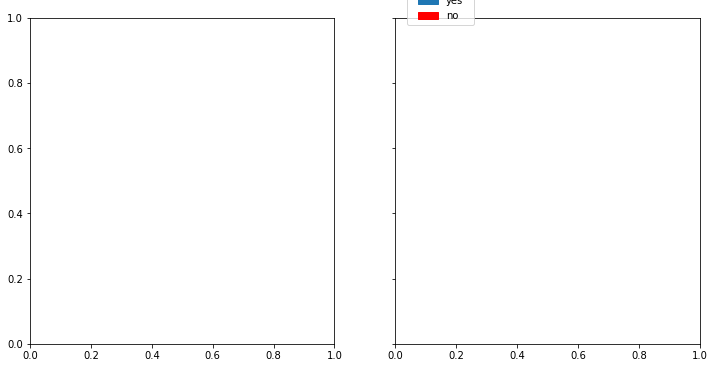

In [49]:
fig, ax = plot_param(param='C(Age, levels=["Y", "A"])[T.A]', results=results_m4, model='Mixed M4')